# Entropy and SVM Anomaly Detection

In [94]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import UgrUtils as utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime
from dateutil.parser import parse
import collections
import math
import time
import os
import subprocess

import graphviz as gv
import hashlib
import pickle

from scipy.stats import entropy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# experiment parameters
timeWindow = 30 * 60 # 30 minutes

In [16]:
# read data
df = pd.read_csv("dataset/2016-06-20_SMTP_100.csv")

In [98]:
df = utils.addTimebin(df, timeWindow)
df.head()

,te,td,sa,da,sp,dp,pr,flg,fwd,stos,pkt,byt,type,timebin
0,2016-06-20 00:07:11,3.324,42.219.145.241,79.28.21.23,25,60052,TCP,.AP.SF,0,0,29,2172,background,814640
1,2016-06-20 00:07:14,1.960,42.219.156.185,108.66.255.250,54726,25,TCP,.APRS.,0,0,10,827,background,814640
2,2016-06-20 00:07:24,0.172,42.91.149.234,42.219.159.90,587,23821,TCP,.AP.S.,0,0,4,342,background,814640
3,2016-06-20 00:07:29,0.812,42.219.156.183,187.35.0.150,48946,25,TCP,.APRS.,0,0,8,515,background,814640
4,2016-06-20 00:07:30,1.024,42.219.158.179,56.10.179.181,25,61138,TCP,.AP.SF,0,0,8,657,background,814640


In [20]:
def ent(data):
    p_data= data.value_counts()/len(data) # calculates the probabilities
    H=entropy(p_data)  # input probabilities to get the entropy 
    return H

In [30]:
def agg(df, features):
    '''
    returns list of entropies of supplied features
    '''
    return [ent(df[feature]) for feature in features]

In [99]:
def aggGroups(dfGroups):
    features = ['sa', 'da', 'sp', 'dp' , 'flg', 'byt']
    data = [[utils.timeBinToDate(l, timeWindow)] + agg(df, features) for l, df in dfGroups]
    columns = ['time'] + ['H({})'.format(f) for f in features]
    return pd.DataFrame(data, columns = columns)

In [102]:
# test
df_agg = aggGroups(df.groupby('timebin'))
df_agg.head()
df_agg.to_csv("temp.csv")

## Anomaly Utils

In [91]:
def timebinAnom(df, anoms):
    # warning, first column of csv has to be changed to 'te' for convenience
    df = utils.addTimebin(df, timeWindow)
    filteredCols = ['timebin'] + anoms
    df = df[filteredCols]
    df_agg = df.groupby('timebin').agg(sum)
    df_agg['time'] = df_agg.apply(lambda row : utils.timeBinToDate(row.name, timeWindow), axis = 1)
    filteredCols = ['time'] + anoms
    print(filteredCols)
    df_agg = df_agg.reset_index()
    df_agg = df_agg[filteredCols]
    return df_agg

In [96]:
anoms = ["anomaly-spam"]
df_anom = pd.read_csv("dataset/attack_ts_june_week4.csv")
df_anom = timebinAnom(df_anom, anoms)
df_anom.head()

['time', 'anomaly-spam']


,time,anomaly-spam
0,2016-06-20 00:00:00,0
1,2016-06-20 00:30:00,0
2,2016-06-20 01:00:00,0
3,2016-06-20 01:30:00,0
4,2016-06-20 02:00:00,0


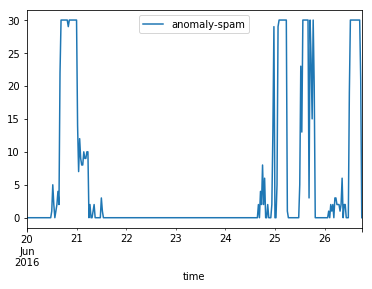

In [97]:
df_anom.plot(x='time', y = anoms)